## A. NLTK NLP Text Analytics Pipeline V1

# 1.00 Installing Libraries and Dependencies

#needs 3.11 for spaCy 

1. conda update -n base -c conda-forge conda
2. conda create -n nltk-env python=3.11                 
3. conda activate nltk-env
4. conda install ipykernel jupyter nltk pandas numpy plotly matplotlib ipywidgets openpyxl seaborn -c conda-forge
5. pip install spacy
6. pip install sentence-transformers scikit-learn textblob nbformat ipython tqdm
6. python -m spacy download en_core_web_sm
7. python -m spacy download en_core_web_trf

## 1.01 NLTK Preprocessing and tokenization for Peeking under the Hood Text Analytics

Running the code cell below will result in us pulling the following token types for each of our seven corpora.
1. word tokens - formed from decomposing sentences into their constituent pieces.
2. NLTK text objects - The NLTK library has a unique tokenizer that adds additional metadata to the word token which allows for unique analysis as compared to normal word tokens.
3. original sentence tokens - based on numerous features, but normally bounded by punctuation marks. This is why we normally tokenize this first before other text processing.
4. normalized sentence tokens - original sentence tokens that have been lowercased, and had stop words, punctuations, and special chracters removed.

You can always figure out what type of data corpus you are dealing with by running these print checks. It is also extremely important to also note the importance of keeping your documents categorized, lest they get out of control. The more processing and feature extractions you do, the more you may end up with more different buckets of data to keep up with.
* We will look at the utility of each token type in these modules

## 1.01 Configuration

*Set up file paths and select the SpaCy model.*

In [1]:
#Setup path to files
import ipywidgets as widgets
from IPython.display import display

# Text input for the path to CSV files
path_input = widgets.Text(
    value='data/data/rawTranscriptFiles/interview_transcripts',
    placeholder='Enter the path to your CSV files',
    description='CSV Path:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

# Text input for the output path
output_path_input = widgets.Text(
    value='data/data/rawTranscriptFiles/interview_transcripts_output',
    placeholder='Enter the output path for processed files',
    description='Output Path:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

# Dropdown for selecting the SpaCy model
model_dropdown = widgets.Dropdown(
    options=['en_core_web_sm', 'en_core_web_md', 'en_core_web_lg'],
    value='en_core_web_sm',
    description='SpaCy Model:',
    disabled=False,
    layout=widgets.Layout(width='50%')
)

# Display the widgets
display(path_input, output_path_input, model_dropdown)


Text(value='data/data/rawTranscriptFiles/interview_transcripts', description='CSV Path:', layout=Layout(width=…

Text(value='data/data/rawTranscriptFiles/interview_transcripts_output', description='Output Path:', layout=Lay…

Dropdown(description='SpaCy Model:', layout=Layout(width='50%'), options=('en_core_web_sm', 'en_core_web_md', …

## 1.02 This button just follows up with the last cell to define the path to the folders. Just push once.

In [2]:
#Define path to the folder containg csv files
# Use the widget values in your code
path_to_csv_files = path_input.value
path_to_csv_files_output = output_path_input.value
model = model_dropdown.value


# 2.00 Data Loading and Preprocessing

*Read CSV files and preprocess text data.*
push this button to set up and preprocess the text from the csv files. Look in the output folder and you should see a new csv file.

In [3]:
import os
import glob
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import re
from textblob import TextBlob  # For sentiment analysis (optional)
from tqdm.notebook import tqdm  # For the progress bar in Jupyter notebooks

# Define the SpaCy model to use (ensure you have downloaded it, e.g., en_core_web_sm)
model = model  # Replace with your desired model if different
nlp = spacy.load(model)

# Download NLTK stopwords and tokenizers
nltk.download('stopwords')
nltk.download('punkt')  # For sentence and word tokenization
stop_words = set(stopwords.words('english'))

# 1. Function to read CSV files from a folder and its subfolders
def read_transcripts_from_folder(base_dir):
    csv_files = glob.glob(os.path.join(base_dir, '**/*.csv'), recursive=True)
    transcripts = []
    for file in tqdm(csv_files, desc="Reading CSV Files", unit="file"):  # Add progress bar here
        df = pd.read_csv(file)
        filename = os.path.splitext(os.path.basename(file))[0]  # Extract filename without extension
        transcripts.append((df, filename))
    return transcripts

# 2. Text preprocessing with SpaCy (no stopword removal yet)
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text using SpaCy
    doc = nlp(text)
    
    # Lemmatize and remove punctuation, no stopword removal yet
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    
    return ' '.join(tokens)

# 3. SpaCy POS, NER, and Dependency parsing analysis
def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]  # Part-of-speech tagging
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Named entity recognition
    dependencies = [(token.text, token.dep_, token.head.text) for token in doc]  # Dependency parsing
    return pos_tags, entities, dependencies

# 4. Sentiment analysis using TextBlob
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity  # Sentiment polarity and subjectivity

# 5. NLTK tokenization and text object creation
def nltk_tokenization_and_text_object(df):
    # Sentence tokens of unprocessed and processed text
    df['nltk_unprocessed_sentence_tokens'] = df['text'].apply(nltk.sent_tokenize)  # Unprocessed sentence tokens
    df['nltk_processed_sentence_tokens'] = df['cleaned_text'].apply(nltk.sent_tokenize)  # Processed sentence tokens
    
    # Word tokens of unprocessed and processed text
    df['nltk_unprocessed_word_tokens'] = df['text'].apply(nltk.word_tokenize)  # Unprocessed word tokens
    df['nltk_processed_word_tokens'] = df['cleaned_text'].apply(nltk.word_tokenize)  # Processed word tokens

    # Create NLTK Text object for the entire transcript
    all_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
    nltk_text_obj = nltk.Text(all_tokens)  # Create NLTK Text object from all tokens
    
    # Store the NLTK Text object in the DataFrame's attributes
    df.attrs['nltk_text_object'] = nltk_text_obj
    
    return df

# 6. Apply preprocessing and analysis to the 'text' column of each CSV
def preprocess_and_analyze_transcripts(transcripts):
    results = []
    
    for df, filename in tqdm(transcripts, desc='Processing Transcripts', unit="transcript"):  # Add progress bar here
        df['cleaned_text'] = df['text'].apply(preprocess_text)  # Preprocess the text
        
        # Apply SpaCy analysis (POS tags, NER, Dependency parsing)
        df['pos_tags'], df['entities'], df['dependencies'] = zip(*df['text'].apply(spacy_analysis))
        
        # Word count and sentence length
        df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
        df['sentence_length'] = df['text'].apply(lambda x: len(x.split()))  # Original text sentence length
        
        # Sentiment analysis (polarity and subjectivity)
        df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['text'].apply(sentiment_analysis))
        
        # Apply NLTK tokenization and text object creation
        df = nltk_tokenization_and_text_object(df)
        
        results.append((df, filename))
    
    return results

# 7. Main pipeline function to process CSV files
def process_csv_files(base_dir):
    # Step 1: Read all transcripts from the CSV files
    transcripts = read_transcripts_from_folder(base_dir)
    
    # Step 2: Preprocess and analyze the transcripts
    processed_transcripts = preprocess_and_analyze_transcripts(transcripts)
    
    return processed_transcripts

# Example usage of the pipeline
if __name__ == "__main__":

    base_dir = path_to_csv_files  # Replace with your actual path containing CSV transcript files
    output_dir = path_to_csv_files_output  # Replace with your desired output directory for processed CSV files
    
    # Ensure the output directory exists (create it if it doesn't)
    os.makedirs(output_dir, exist_ok=True)
    
    # Process the CSV files
    processed_transcripts = process_csv_files(base_dir)
    
    # Save the processed CSV files with original filenames
    for df, filename in tqdm(processed_transcripts, desc="Saving CSV Files", unit="file"):  # Add progress bar here
        # Define the desired column order
        column_order = [
            'sentence_number', 'speaker', 'cleaned_text', 'entities', 'word_count', 'sentence_length', 
            'sentiment_polarity', 'sentiment_subjectivity', 'nltk_unprocessed_sentence_tokens', 
            'nltk_processed_sentence_tokens', 'nltk_unprocessed_word_tokens', 'nltk_processed_word_tokens', 
            'pos_tags', 'dependencies'
        ]
        
        # Ensure all columns exist in the DataFrame to prevent KeyError
        existing_columns = [col for col in column_order if col in df.columns]
        
        # Save the DataFrame with reordered columns
        output_filename = f'processed_transcript_{filename}.csv'
        df[existing_columns].to_csv(os.path.join(output_dir, output_filename), index=False)
        
        print(f"Processed file saved as: {output_filename}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading CSV Files:   0%|          | 0/7 [00:00<?, ?file/s]

Processing Transcripts:   0%|          | 0/7 [00:00<?, ?transcript/s]

Saving CSV Files:   0%|          | 0/7 [00:00<?, ?file/s]

Processed file saved as: processed_transcript_20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240531_INT_MS_Vera_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240531_INT_MS_Xander_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240603_INT_MS_Uma_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240606_INT_MS_Gloria_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240612_INT_HS_Charles_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240718_INT_HS_Neil_2024-08-07_transcription.csv


## 2.01
Merge some variables together. Just push

In [4]:
for df, filename in processed_transcripts:
    nltk_text_obj = df.attrs['nltk_text_object']
    # Now you can use nltk_text_obj for concordance

print(nltk_text_obj[0:10])  # Display the first 10 tokens
type(nltk_text_obj)

['Great', '.', 'Yeah', ',', 'so', 'to', 'get', 'off', ',', 'just']


nltk.text.Text

## 2.02 Checking the dataframes
Printing the first set of rows from a transcript to check that things are working. Just push

In [5]:
# Print the first 10 rows of the first processed transcript
print(processed_transcripts[0][0].head(10))


     start      end                                               text  \
0   81.627   83.749                  OK, so I'll start recording then.   
1   84.229   84.650                                         All right.   
2   85.290   87.272                                  It's going great.   
3   87.492   87.872                                                OK.   
4   89.574   93.277  Yeah, so just a little bit first to kind of ge...   
5   93.957   95.118                          So what are you teaching?   
6   96.379   99.402  And are you involved in any roles outside of t...   
7   99.842  107.569  Yeah, so I currently teach biology, AP environ...   
8  108.390  110.852       It's like a 20-minute homeroom for freshmen.   
9  110.932  115.296  So they have a half lunch period and half this...   

                                               words     speaker  \
0  [{'word': 'OK,', 'start': 81.627, 'end': 81.98...  SPEAKER_02   
1  [{'word': 'All', 'start': 84.229, 'end': 84.36

## 2.03 Filter stop words

Cleans out repetitive words

In [6]:
# Combine all tokens from 'nltk_unprocessed_word_tokens' column
all_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()

# Filter out stopwords and non-alphabetic tokens
filtered_tokens = [word for word in all_tokens if word.lower() not in stop_words and word.isalpha()]

# Create NLTK Text object
nltk_text_obj_clean = nltk.Text(filtered_tokens)

# 3.00 Peeking Under The Hood Text Analytics 

## 3.01 Average Sentence Length
Average Sentence Length uses the total number of words and total number of sentences
in a corpus to calculate exactly what it says: the average sentence length.
While the equation is very basic and straightforward it provides information that can
be used to infer, for example, how complex sentences are on average throughout a
given text corpus.

In [7]:
from tqdm.notebook import tqdm  # For Jupyter notebooks; use 'tqdm' if running as a script
import pandas as pd

# 1. Function to calculate and print metrics (sentence and word count, average sentence length)
def calculate_metrics(processed_transcripts):
    metrics_list = []  # List to store all metrics

    # Initialize tqdm progress bar over the processed_transcripts
    for i, (df, filename) in enumerate(tqdm(processed_transcripts, desc='Calculating Metrics', unit='transcript')):
        # Retrieve sentence and word tokens from the DataFrame
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN

        # Ensure there are sentences to avoid division by zero
        if len(sentence_tokens) > 0:
            average_sentence_length = len(word_tokens) / len(sentence_tokens)
        else:
            average_sentence_length = 0  # Default to zero if no sentences

        # Store metrics in a dictionary
        metrics = {
            'Transcript': filename,
            'Number of sentences': len(sentence_tokens),
            'Number of word tokens': len(word_tokens),
            'Average sentence length': average_sentence_length
        }
        metrics_list.append(metrics)

        # Prepare the result string
        result = f"\nTranscript {i + 1} ({filename}):\n" \
                 f"Number of sentences: {len(sentence_tokens)}\n" \
                 f"Number of word tokens: {len(word_tokens)}\n" \
                 f"Average sentence length: {average_sentence_length:.2f}"

        # Use tqdm.write() to print without disrupting the progress bar
        tqdm.write(result)

    # Convert the list of metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df

# 2. Run the function and get the DataFrame
metrics_df = calculate_metrics(processed_transcripts)


Calculating Metrics:   0%|          | 0/7 [00:00<?, ?transcript/s]


Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
Number of sentences: 1330
Number of word tokens: 20998
Average sentence length: 15.79

Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
Number of sentences: 663
Number of word tokens: 9991
Average sentence length: 15.07

Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
Number of sentences: 570
Number of word tokens: 8019
Average sentence length: 14.07

Transcript 4 (20240603_INT_MS_Uma_2024-08-07_transcription):
Number of sentences: 860
Number of word tokens: 14700
Average sentence length: 17.09

Transcript 5 (20240606_INT_MS_Gloria_2024-08-07_transcription):
Number of sentences: 594
Number of word tokens: 10698
Average sentence length: 18.01

Transcript 6 (20240612_INT_HS_Charles_2024-08-07_transcription):
Number of sentences: 545
Number of word tokens: 8650
Average sentence length: 15.87

Transcript 7 (20240718_INT_HS_Neil_2024-08-07_transcription):
Number of sentences: 516
Number of word

## 3.02 Average Word Length Distribution
Another fairly straightforward measure that can provide insight into how long, on average, words are in a given corpus.

In [8]:
from tqdm.notebook import tqdm  # For Jupyter notebooks; use 'tqdm' if running as a script

# 1. Function to calculate and print metrics (sentence and word count, average sentence length)
def calculate_metrics(processed_transcripts):
    # Initialize tqdm progress bar over the processed_transcripts
    for i, (df, filename) in enumerate(tqdm(processed_transcripts, desc='Calculating Metrics', unit='transcript')):
        # Retrieve sentence and word tokens from the DataFrame
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN

        # Ensure there are sentences to avoid division by zero
        if sentence_tokens:
            average_sentence_length = len(word_tokens) / len(sentence_tokens)
        else:
            average_sentence_length = 0  # Default to zero if no sentences

        # Use tqdm.write() to print without disrupting the progress bar
        result = f"\nTranscript {i + 1} ({filename}):\n" \
                 f"Number of sentences: {len(sentence_tokens)}\n" \
                 f"Number of word tokens: {len(word_tokens)}\n" \
                 f"Average sentence length: {average_sentence_length:.2f}"
        tqdm.write(result)

# 2. Run the metric calculation on the processed transcripts
calculate_metrics(processed_transcripts)


Calculating Metrics:   0%|          | 0/7 [00:00<?, ?transcript/s]


Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
Number of sentences: 1330
Number of word tokens: 20998
Average sentence length: 15.79

Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
Number of sentences: 663
Number of word tokens: 9991
Average sentence length: 15.07

Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
Number of sentences: 570
Number of word tokens: 8019
Average sentence length: 14.07

Transcript 4 (20240603_INT_MS_Uma_2024-08-07_transcription):
Number of sentences: 860
Number of word tokens: 14700
Average sentence length: 17.09

Transcript 5 (20240606_INT_MS_Gloria_2024-08-07_transcription):
Number of sentences: 594
Number of word tokens: 10698
Average sentence length: 18.01

Transcript 6 (20240612_INT_HS_Charles_2024-08-07_transcription):
Number of sentences: 545
Number of word tokens: 8650
Average sentence length: 15.87

Transcript 7 (20240718_INT_HS_Neil_2024-08-07_transcription):
Number of sentences: 516
Number of word

## 3.03 Lexical Diversity
Lexical diversity quantifies the variety of unique words found in a document. It produces a numerical measure that indicates how diverse the vocabulary is that is used in a text. Broadly speaking, scores of (0.8 - 1) are considered extremely high and difficult to maintain in typical communicative texts. Scores of 0.4-0.79 are considered moderate to high; most high-quality texts fall in this range. Scores of (0 - 0.39) are considered low lexical diversity and tend to suggest highly specialized or technical language usage (e.g., instruction manuals) or language aimed at young readers. This measure is sensitive to corpus length (longer corpora have more opportunities to repeat words), but comparing lexical diversity scores can allow for quantitative comparison that might suggest potential changes in how the usage of language may differ between groups.

In [9]:
from nltk.corpus import stopwords
import string

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def calculate_lexical_diversity(processed_transcripts):
    for df, filename in processed_transcripts:
        nltk_text_obj = df.attrs.get('nltk_text_object', None)
        
        if nltk_text_obj is not None:
            # Filter tokens: remove stopwords and punctuation, and convert to lowercase
            filtered_tokens = [
                word.lower() for word in nltk_text_obj
                if word.lower() not in stop_words and word.isalpha()
            ]
            
            total_words = len(filtered_tokens)
            unique_words = len(set(filtered_tokens))
            lexical_diversity = unique_words / total_words if total_words > 0 else 0
            print(f"Lexical diversity for {filename}: {lexical_diversity:.3f}")
        else:
            print(f"No NLTK Text object available for {filename}")

calculate_lexical_diversity(processed_transcripts)

Lexical diversity for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription: 0.198
Lexical diversity for 20240531_INT_MS_Vera_2024-08-07_transcription: 0.229
Lexical diversity for 20240531_INT_MS_Xander_2024-08-07_transcription: 0.248
Lexical diversity for 20240603_INT_MS_Uma_2024-08-07_transcription: 0.222
Lexical diversity for 20240606_INT_MS_Gloria_2024-08-07_transcription: 0.204
Lexical diversity for 20240612_INT_HS_Charles_2024-08-07_transcription: 0.305
Lexical diversity for 20240718_INT_HS_Neil_2024-08-07_transcription: 0.293


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.04 Unique Words Over Time
Unique words can be used to identify the frequency of words that appear only once in a given corpus. We can also print a list of these word tokens. Looking at unique words between or across text corpora can allow us to look for the appearances and disappearances of specialized educational terminology over time. To find the frequency (number) of unique words, use the following code:

In [10]:
# 1. Function to calculate and print the number of unique words for each transcript
def calculate_unique_words(processed_transcripts):
    for i, (df, filename) in enumerate(processed_transcripts):
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Calculate the number of unique words
        unique_words = set(word_tokens)
        unique_word_count = len(unique_words)

        # Print results for each transcript
        print(f"\nTranscript {i + 1} ({filename}):")
        print("Number of unique words:", unique_word_count)

# 2. Run the unique word count calculation on the processed transcripts
calculate_unique_words(processed_transcripts)





Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
Number of unique words: 1806

Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
Number of unique words: 1000

Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
Number of unique words: 918

Transcript 4 (20240603_INT_MS_Uma_2024-08-07_transcription):
Number of unique words: 1333

Transcript 5 (20240606_INT_MS_Gloria_2024-08-07_transcription):
Number of unique words: 1030

Transcript 6 (20240612_INT_HS_Charles_2024-08-07_transcription):
Number of unique words: 1122

Transcript 7 (20240718_INT_HS_Neil_2024-08-07_transcription):
Number of unique words: 1021


## 3.05 Most common used words by corpus

In [11]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import nltk

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Calculate and print the top 10 most common words for each transcript
def calculate_most_common_words(processed_transcripts, top_n=10):
    for df, filename in processed_transcripts:
        # Retrieve the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs.get('nltk_text_object', None)
        
        if nltk_text_obj is not None:
            # Filter out stopwords and non-alphabetic tokens, and convert to lowercase
            filtered_tokens = [
                word.lower() for word in nltk_text_obj
                if word.lower() not in stop_words and word.isalpha()
            ]
            
            # Create a frequency distribution
            fdist = FreqDist(filtered_tokens)
            
            # Get the top N most common words
            most_common = fdist.most_common(top_n)
            
            print(f"Top {top_n} most common words in {filename}:")
            for word, frequency in most_common:
                print(f"{word}: {frequency}")
            print("\n")
        else:
            print(f"No NLTK Text object available for {filename}")

# 2. Run the frequency distribution calculation on the processed transcripts
calculate_most_common_words(processed_transcripts)


Top 10 most common words in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
like: 442
think: 240
know: 225
right: 173
yeah: 168
really: 139
students: 111
going: 100
things: 99
lot: 74


Top 10 most common words in 20240531_INT_MS_Vera_2024-08-07_transcription:
like: 357
yeah: 98
know: 85
okay: 72
um: 61
really: 46
oh: 41
going: 36
would: 31
get: 30


Top 10 most common words in 20240531_INT_MS_Xander_2024-08-07_transcription:
like: 170
kind: 116
yeah: 85
students: 49
really: 48
okay: 47
think: 35
get: 32
things: 31
would: 30


Top 10 most common words in 20240603_INT_MS_Uma_2024-08-07_transcription:
know: 260
like: 208
kind: 138
yeah: 80
science: 72
really: 71
things: 67
want: 62
going: 61
one: 59


Top 10 most common words in 20240606_INT_MS_Gloria_2024-08-07_transcription:
like: 527
think: 137
yeah: 105
um: 86
know: 75
things: 71
really: 52
okay: 46
kind: 44
feel: 44


Top 10 most common words in 20240612_INT_HS_Charles_2024-08-07_transcription:
like: 163
know: 87
think: 39
righ

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.06 Display all unique words found in a corpus

In [12]:
from nltk.corpus import stopwords
import string

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Create a dictionary where each key is the transcript filename and value is a set of word tokens
corpora_tokens = {}
for df, filename in processed_transcripts:
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Flatten the word tokens and filter out stopwords and non-alphabetic words
        tokens = set(
            word.lower() for word in df['nltk_unprocessed_word_tokens'].explode().tolist()
            if word.lower() not in stop_words and word.isalpha()
        )
        corpora_tokens[filename] = tokens
    else:
        print(f"'nltk_unprocessed_word_tokens' not found in {filename}")

# 2. Function to find words unique to each transcript compared to others
def find_unique_words(corpora_tokens):
    unique_words = {}
    for corpus_name, tokens in corpora_tokens.items():
        # Collect all tokens from other transcripts
        all_other_tokens = set()
        for other_corpus_name, other_tokens in corpora_tokens.items():
            if corpus_name != other_corpus_name:
                all_other_tokens.update(other_tokens)
        
        # Unique words are those not present in other transcripts
        unique_words[corpus_name] = tokens - all_other_tokens
    return unique_words

# 3. Find words unique to each transcript
unique_words_by_transcript = find_unique_words(corpora_tokens)

# 4. Print unique words for each transcript
for transcript_name, unique_words in unique_words_by_transcript.items():
    print(f"\nWords exclusive to {transcript_name}:")
    print(sorted(unique_words))



Words exclusive to 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
['abilities', 'absence', 'absenteeism', 'absolute', 'abysmally', 'academic', 'academically', 'accept', 'acknowledge', 'addendum', 'addiction', 'addictive', 'additionally', 'address', 'addresses', 'advisor', 'advocacy', 'advocating', 'air', 'albinism', 'allstate', 'alone', 'alternative', 'ama', 'american', 'amok', 'among', 'amorphous', 'amounts', 'amta', 'andrew', 'anecdotes', 'animals', 'antibiotic', 'app', 'arctic', 'association', 'assumptions', 'attempts', 'attitude', 'august', 'auto', 'backgrounds', 'badass', 'balanced', 'bar', 'battle', 'bearing', 'beautiful', 'bed', 'beef', 'beforehand', 'behaviorally', 'benefits', 'biochem', 'blah', 'blast', 'blue', 'brave', 'breakdown', 'brother', 'brush', 'buckle', 'bump', 'buzzing', 'cafe', 'campus', 'canada', 'canceled', 'candy', 'card', 'carrot', 'cases', 'caveats', 'celebrate', 'central', 'challenged', 'champagne', 'charm', 'checked', 'chemphys', 'chicken', 'chill', 'c

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.07 Most frequently used words across all corpora:

In [13]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Aggregate all word tokens from all transcripts into a single list
all_tokens = []
for df, filename in processed_transcripts:  # Unpack the tuple (DataFrame, filename)
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Flatten the word tokens
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()
        
        # Filter out stopwords and non-alphabetic tokens, and convert to lowercase
        filtered_tokens = [
            word.lower() for word in word_tokens
            if word.lower() not in stop_words and word.isalpha()
        ]
        
        all_tokens.extend(filtered_tokens)
    else:
        print(f"'nltk_unprocessed_word_tokens' not found in {filename}")

# 2. Calculate the frequency distribution of all tokens
token_freq_dist = Counter(all_tokens)

# 3. Find the most common words across all transcripts (adjust the number as needed)
most_common_words = token_freq_dist.most_common(100)

# 4. Function to print data in columns
def print_in_columns(data, columns=3):
    # Split the data into chunks of size 'columns'
    for i in range(0, len(data), columns):
        chunk = data[i:i + columns]
        # Format and print each chunk
        print("  ".join(f"{word}: {freq}" for word, freq in chunk))

# 5. Print the most common words in columns
print("Most frequently used words across all transcripts:")
print_in_columns(most_common_words, columns=1)


Most frequently used words across all transcripts:
like: 1987
know: 785
yeah: 606
think: 557
kind: 426
really: 393
things: 338
students: 302
right: 294
okay: 293
going: 284
um: 271
get: 232
year: 217
science: 214
one: 213
would: 200
lot: 199
want: 183
school: 176
something: 175
well: 151
go: 140
unit: 140
little: 132
also: 131
time: 125
feel: 124
see: 122
kids: 121
curriculum: 120
mean: 118
work: 117
got: 117
make: 114
oh: 113
way: 113
different: 113
thing: 112
trying: 112
classroom: 109
teaching: 107
use: 104
last: 102
grade: 101
could: 96
sometimes: 93
maybe: 93
class: 92
say: 91
teacher: 90
much: 90
working: 87
student: 86
bit: 84
try: 84
need: 81
sort: 80
development: 80
years: 80
day: 78
back: 78
great: 77
talking: 77
actually: 77
professional: 76
good: 76
probably: 75
might: 73
questions: 73
even: 73
talk: 72
still: 72
done: 70
two: 68
said: 67
always: 67
ownership: 67
people: 66
part: 66
thinking: 65
look: 64
first: 63
teach: 62
next: 62
come: 62
every: 61
summer: 60
cool: 60
ge

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 4.00 NLTK Text Objects

## 4.01 N-grams and collocations
N-grams point out recurring word combinations found throughout the text corpus. For example, "spring break" is an example of a bigrams while "New York City" is a trigrams. Bigrams and repeated collocations of words convey a lot of information about the contents of the text corpus.
To generate an ordered list of the most common bigrams, use the following code:

In [14]:
import nltk
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Loop through each transcript to find and display top bigrams and trigrams
for i, (df, filename) in enumerate(processed_transcripts):  # Unpack the tuple (DataFrame, filename)
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Filter out stopwords and non-alphabetic tokens, and convert to lowercase
        filtered_tokens = [
            word.lower() for word in word_tokens
            if word.lower() not in stop_words and word.isalpha()
        ]

        # Display frequency of highest 50 bigrams
        print(f"\nTop 50 bigrams for Transcript {i + 1} ({filename}):")
        bigram_finder = BigramCollocationFinder.from_words(filtered_tokens)

        # Apply frequency filter to remove less frequent bigrams (optional)
        bigram_finder.apply_freq_filter(2)  # Adjust the minimum frequency as needed

        # Get the top 50 bigrams using raw frequency
        bigrams = bigram_finder.ngram_fd.most_common(50)
        for bigram, freq in bigrams:
            print(f"{bigram}: {freq}")

        # Display frequency of highest 50 trigrams
        print(f"\nTop 50 trigrams for Transcript {i + 1} ({filename}):")
        trigram_finder = TrigramCollocationFinder.from_words(filtered_tokens)

        # Apply frequency filter to remove less frequent trigrams (optional)
        trigram_finder.apply_freq_filter(2)  # Adjust the minimum frequency as needed

        # Get the top 50 trigrams using raw frequency
        trigrams = trigram_finder.ngram_fd.most_common(50)
        for trigram, freq in trigrams:
            print(f"{trigram}: {freq}")

    else:
        print(f"'nltk_unprocessed_word_tokens' column not found in {filename}")

    print("\n")



Top 50 bigrams for Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
('know', 'mean'): 36
('know', 'like'): 36
('things', 'like'): 31
('yeah', 'yeah'): 24
('like', 'know'): 24
('right', 'like'): 22
('mean', 'like'): 21
('gon', 'na'): 18
('like', 'oh'): 14
('think', 'sometimes'): 14
('like', 'yeah'): 13
('little', 'bit'): 12
('like', 'really'): 12
('like', 'think'): 12
('yeah', 'like'): 11
('also', 'think'): 11
('last', 'year'): 11
('professional', 'development'): 10
('think', 'lot'): 10
('right', 'think'): 10
('next', 'year'): 9
('students', 'like'): 9
('okay', 'yeah'): 8
('really', 'hard'): 8
('think', 'students'): 8
('like', 'right'): 8
('yeah', 'know'): 8
('school', 'know'): 7
('really', 'good'): 7
('like', 'going'): 7
('yeah', 'okay'): 7
('think', 'really'): 7
('sounds', 'like'): 7
('know', 'know'): 7
('cool', 'cool'): 7
('right', 'yeah'): 6
('right', 'want'): 6
('day', 'day'): 6
('like', 'okay'): 6
('know', 'yeah'): 6
('talk', 'like'): 6
('lot', 'students'): 6
(

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4.02 Concordance
Concordance is an NLTK Text object method that also looks for word distribution, but specifically searches for words found before and after a specific word of choice. Concordance allows us to find out how words are used contextually throughout a corpus. This can be particularly powerful when looking at trends over time or between groups. For example, in the sample below we search for the all the contextual occurrences of the word “pi” in our seven separate corpora.

In [15]:
import ipywidgets as widgets
from IPython.display import display
import nltk

# Function to display concordance results for the selected word
def show_concordance(word_to_search):
    for df, filename in processed_transcripts:
        nltk_text_obj = df.attrs['nltk_text_object']
        print(f"Concordance for '{word_to_search}' in {filename}:")
        try:
            nltk_text_obj.concordance(word_to_search, width=150)
        except Exception as e:
            print(f"Error in {filename}: {e}")
        print("\n")

# Function to update and display concordance based on user input
def on_button_click(b):
    word_to_search = word_input.value  # Get the user input word
    if word_to_search:  # If the user provided a word
        show_concordance(word_to_search)
    else:
        print("Please enter a word to search for concordance.")

# Create a text box for user input
word_input = widgets.Text(
    value='equity',  # Default word
    description='Search word:',
    disabled=False
)

# Create a button to trigger the concordance search
search_button = widgets.Button(
    description='Search Concordance',
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to search for the word in transcripts'
)

# Attach an event listener to the button click
search_button.on_click(on_button_click)

# Display the input box and the button
display(word_input, search_button)


Text(value='equity', description='Search word:')

Button(button_style='success', description='Search Concordance', style=ButtonStyle(), tooltip='Click to search…

Concordance for 'equity' in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
Displaying 4 of 4 matches:
 I 'm going to say equitable , because I also think that we have a huge equity issue right now in education , in that I do n't think that we are expec
ut of them and not teaching them as in-depth a content amount is a huge equity issue . You know what I mean ? Like if we 're not , if we 're teaching 
ink it 's often done in the name of , in sort of falsely in the name of equity , you know what I mean ? Like , I think that there 's a lot of linguist
ot by saying we 're not going to read because I think that gets to that equity issue and exacerbates our problem , right ? Like we need our students t


Concordance for 'equity' in 20240531_INT_MS_Vera_2024-08-07_transcription:
no matches


Concordance for 'equity' in 20240531_INT_MS_Xander_2024-08-07_transcription:
Displaying 1 of 1 matches:
hing . But most of our PDs is kind of surrounded by engaging students , equity for students , 

# 5.00 Word usage visualizations

## 5.01 Context Dispersion Plot:

Text(value='equity, students, teachers', description='Words to track:', placeholder='Enter words separated by …

Button(button_style='success', description='Create Dispersion Plot', style=ButtonStyle(), tooltip='Click to cr…

Dispersion plot for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:


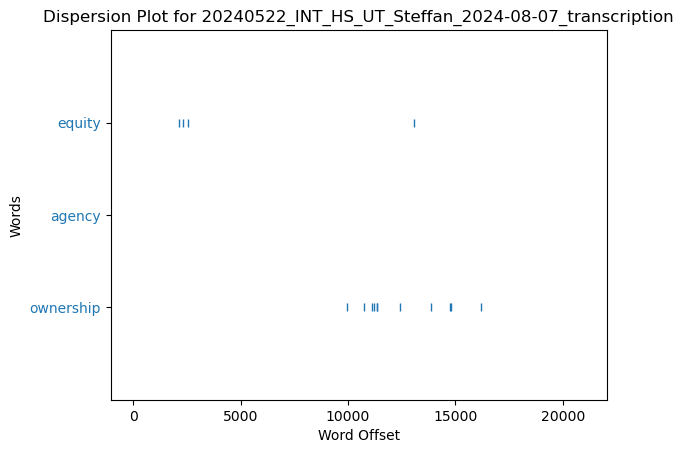

Dispersion plot for 20240531_INT_MS_Vera_2024-08-07_transcription:


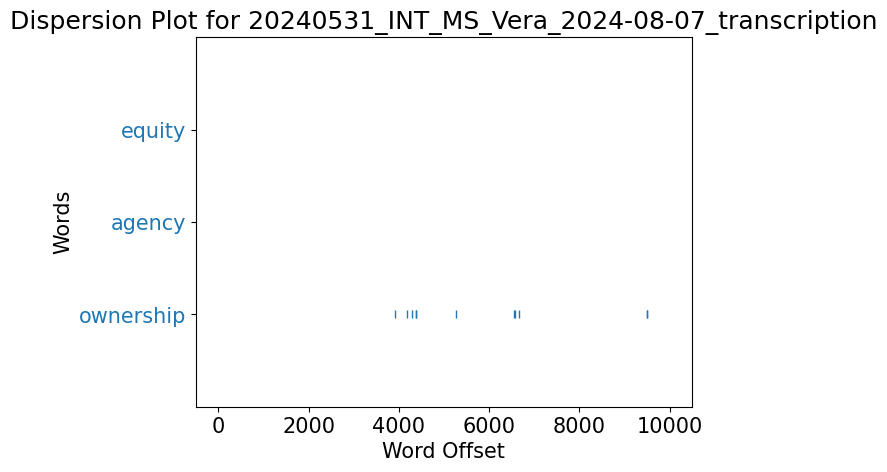

Dispersion plot for 20240531_INT_MS_Xander_2024-08-07_transcription:


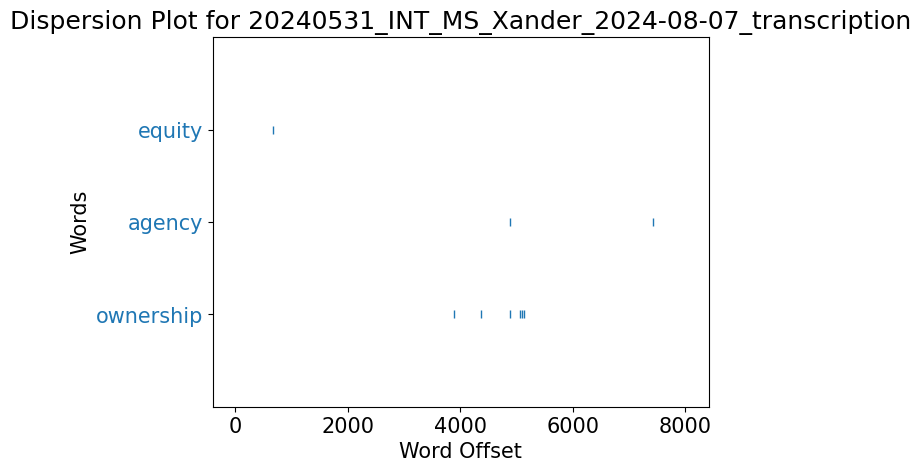

Dispersion plot for 20240603_INT_MS_Uma_2024-08-07_transcription:


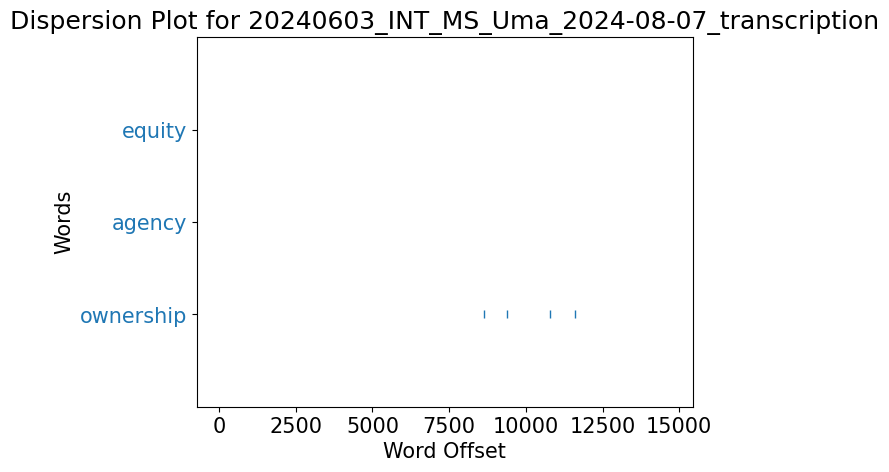

Dispersion plot for 20240606_INT_MS_Gloria_2024-08-07_transcription:


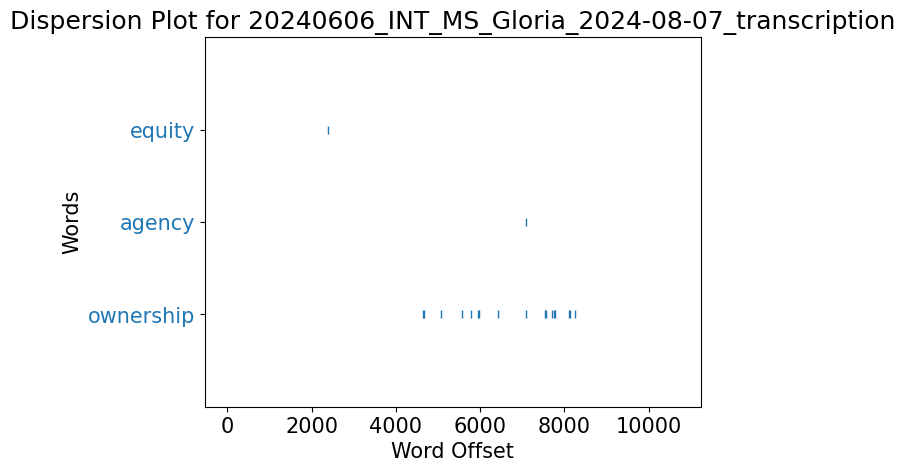

Dispersion plot for 20240612_INT_HS_Charles_2024-08-07_transcription:


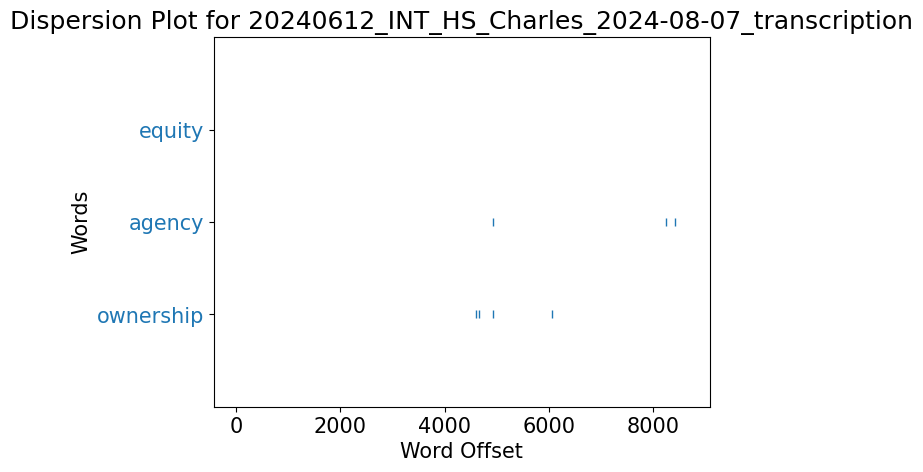

Dispersion plot for 20240718_INT_HS_Neil_2024-08-07_transcription:


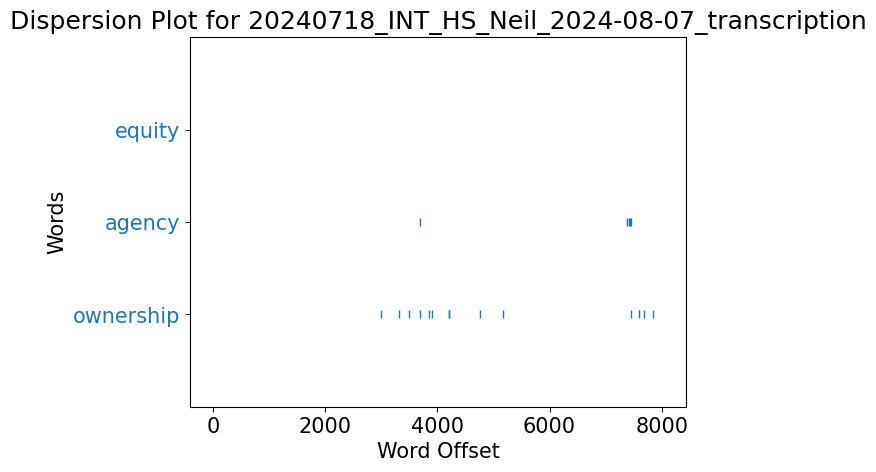

In [16]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import nltk

# Function to create the dispersion plot based on user input words
def create_dispersion_plots(words_to_track):
    words_to_track = [word.lower().strip() for word in words_to_track]  # Ensure lowercase and no spaces

    # Loop through each transcript and create the dispersion plot
    for df, filename in processed_transcripts:
        # Retrieve the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs.get('nltk_text_object', None)

        if nltk_text_obj is not None:
            print(f"Dispersion plot for {filename}:")
            try:
                # Create the dispersion plot
                nltk_text_obj.dispersion_plot(words_to_track)
                plt.title(f"Dispersion Plot for {filename}")
                plt.xlabel('Word Offset')
                plt.ylabel('Words')
                plt.show()  # Show the plot for each file
                plt.rcParams.update({'font.size': 15})

            except Exception as e:
                print(f"Error in {filename}: {e}")
        else:
            print(f"No NLTK Text object available for {filename}")

# Function to handle button click and trigger the dispersion plot creation
def on_button_click(b):
    words_input = words_input_box.value  # Get user input
    if words_input:
        words_to_track = [word.strip() for word in words_input.split(',')]  # Split input into words
        create_dispersion_plots(words_to_track)
    else:
        print("Please enter at least one word to track.")

# Create a text input box for user input
words_input_box = widgets.Text(
    value='equity, students, teachers',  # Default words
    description='Words to track:',
    placeholder='Enter words separated by commas'
)

# Create a button to trigger the dispersion plot generation
plot_button = widgets.Button(
    description='Create Dispersion Plot',
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to create the dispersion plot'
)

# Attach the button click event
plot_button.on_click(on_button_click)

# Display the input box and the button
display(words_input_box, plot_button)


## 5.02 Bag of Words Frequency Distribution with Plots
This will search for each word in the bag of words to find its frequency in each text corpus.

Text(value='want, time, thinking, think, teaching', description='Keywords:', placeholder='Enter keywords separ…

Button(button_style='success', description='Create Keyword Plot', style=ButtonStyle(), tooltip='Click to creat…

Plotting Keywords:   0%|          | 0/7 [00:00<?, ?it/s]

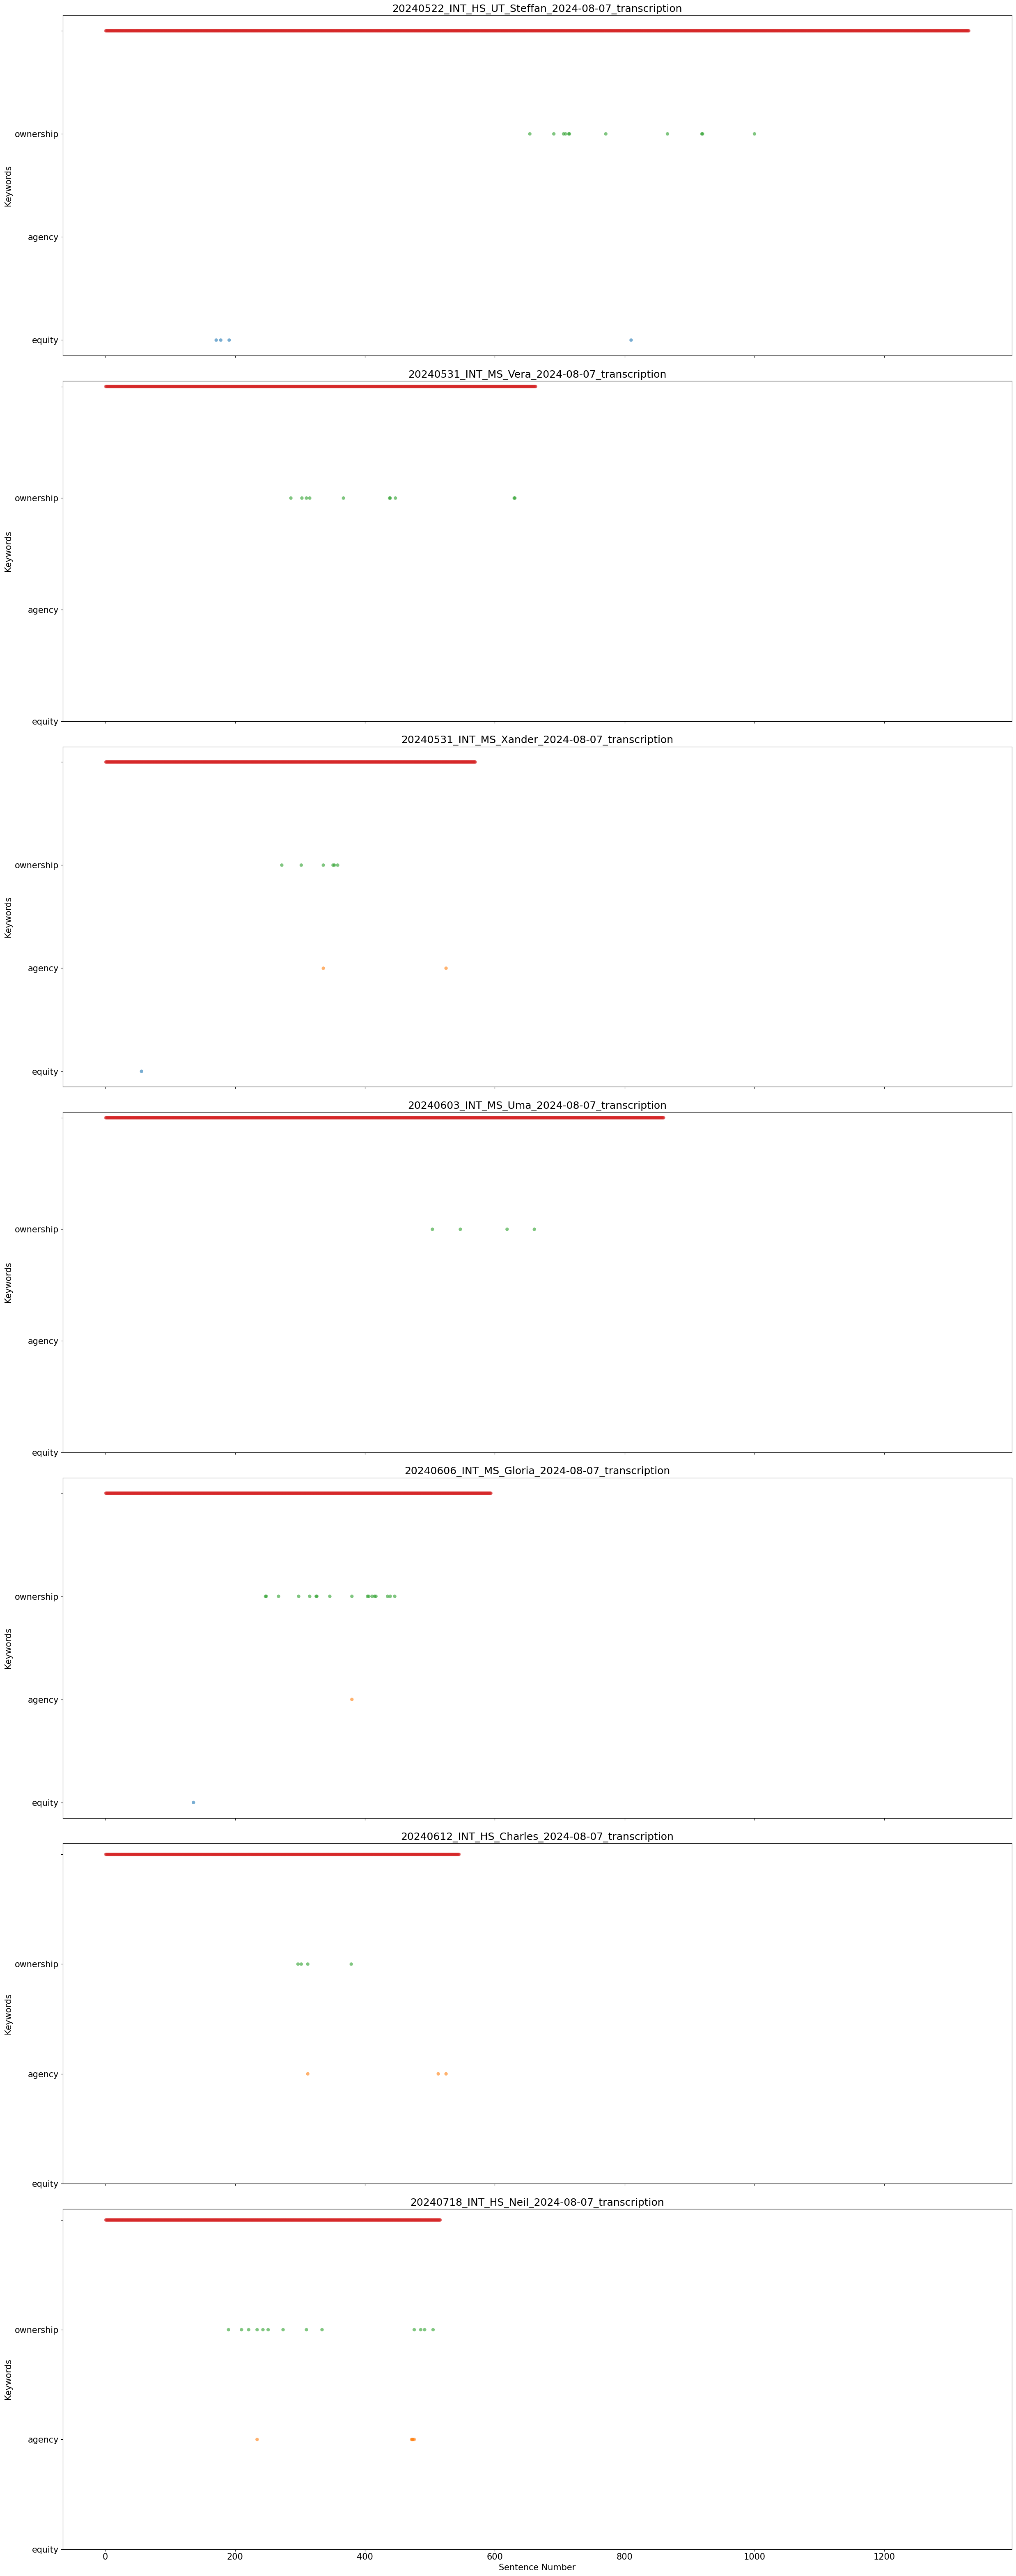

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm  # For progress bars in Jupyter notebooks

# Predefined keywords to track (users can add their own)
predefined_keywords = sorted(set([
    'students', 'science', 'engagement', 'ability', 'community', 'talk',
    'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations',
    'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
    'engaging', 'literacy', 'kids', 'connect', 'student', 'classroom',
    'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking',
    'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'questions',
    'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'conversation',
    'hard', 'saying'
]), reverse=True)

# Function to create keyword occurrence plots
def plot_keyword_occurrences(keywords_to_track):
    keywords_to_track = [keyword.lower().strip() for keyword in keywords_to_track]
    keyword_mapping = {keyword: i for i, keyword in enumerate(keywords_to_track)}

    # Number of transcripts (corpora)
    num_corpora = len(processed_transcripts)

    # Create subplots for each transcript
    fig, axes = plt.subplots(num_corpora, 1, figsize=(25, num_corpora * 9), sharex=True)

    # Convert axes to an array if it's not (happens when num_corpora is 1)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # Iterate over each transcript and plot keyword occurrences
    for ax, (i, (df, filename)) in zip(axes, enumerate(tqdm(processed_transcripts, desc='Plotting Keywords'))):
        corpus_name = os.path.basename(filename)
        ax.set_title(f"{corpus_name}")
        
        # Check if 'nltk_unprocessed_sentence_tokens' column exists
        if 'nltk_unprocessed_sentence_tokens' in df.columns:
            # Get the sentence tokens from each transcript
            sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
            
            # Plot the occurrences of each keyword
            for keyword in keywords_to_track:
                occurrences = [(i + 1, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
                sentence_nums = [occ[1] for occ in occurrences]
                
                y_values = np.full(len(sentence_nums), keyword_mapping[keyword])
                ax.scatter(sentence_nums, y_values, label=keyword, alpha=0.6, edgecolors='none')
            
            ax.set_yticks(list(keyword_mapping.values()))
            ax.set_yticklabels(list(keyword_mapping.keys()))
            ax.set_ylabel('Keywords')
        else:
            print(f"'nltk_unprocessed_sentence_tokens' column not found in {filename}")
            continue  # Skip this transcript if the required column is missing

    # Adjust layout and labels
    plt.xlabel('Sentence Number')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure to an image file before displaying
    plt.savefig('data/my_keyword_plots.png', bbox_inches='tight')

    plt.show()

# Function to handle the plot button click event
def on_plot_button_click(b):
    keywords_input = keyword_input_box.value  # Get user input
    if keywords_input:
        keywords_to_track = [keyword.strip() for keyword in keywords_input.split(',')]
        plot_keyword_occurrences(keywords_to_track)
    else:
        print("Please enter at least one keyword to track.")

# Text box for user input of keywords
keyword_input_box = widgets.Text(
    value=', '.join(predefined_keywords[:5]),  # Default words (first 5 predefined)
    description='Keywords:',
    placeholder='Enter keywords separated by commas'
)

# Button to trigger the plotting
plot_button = widgets.Button(
    description='Create Keyword Plot',
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to create the keyword occurrence plot'
)

# Attach the button click event
plot_button.on_click(on_plot_button_click)

# Display the input box and the button
display(keyword_input_box, plot_button)


## 5.03 Plotting numerous words

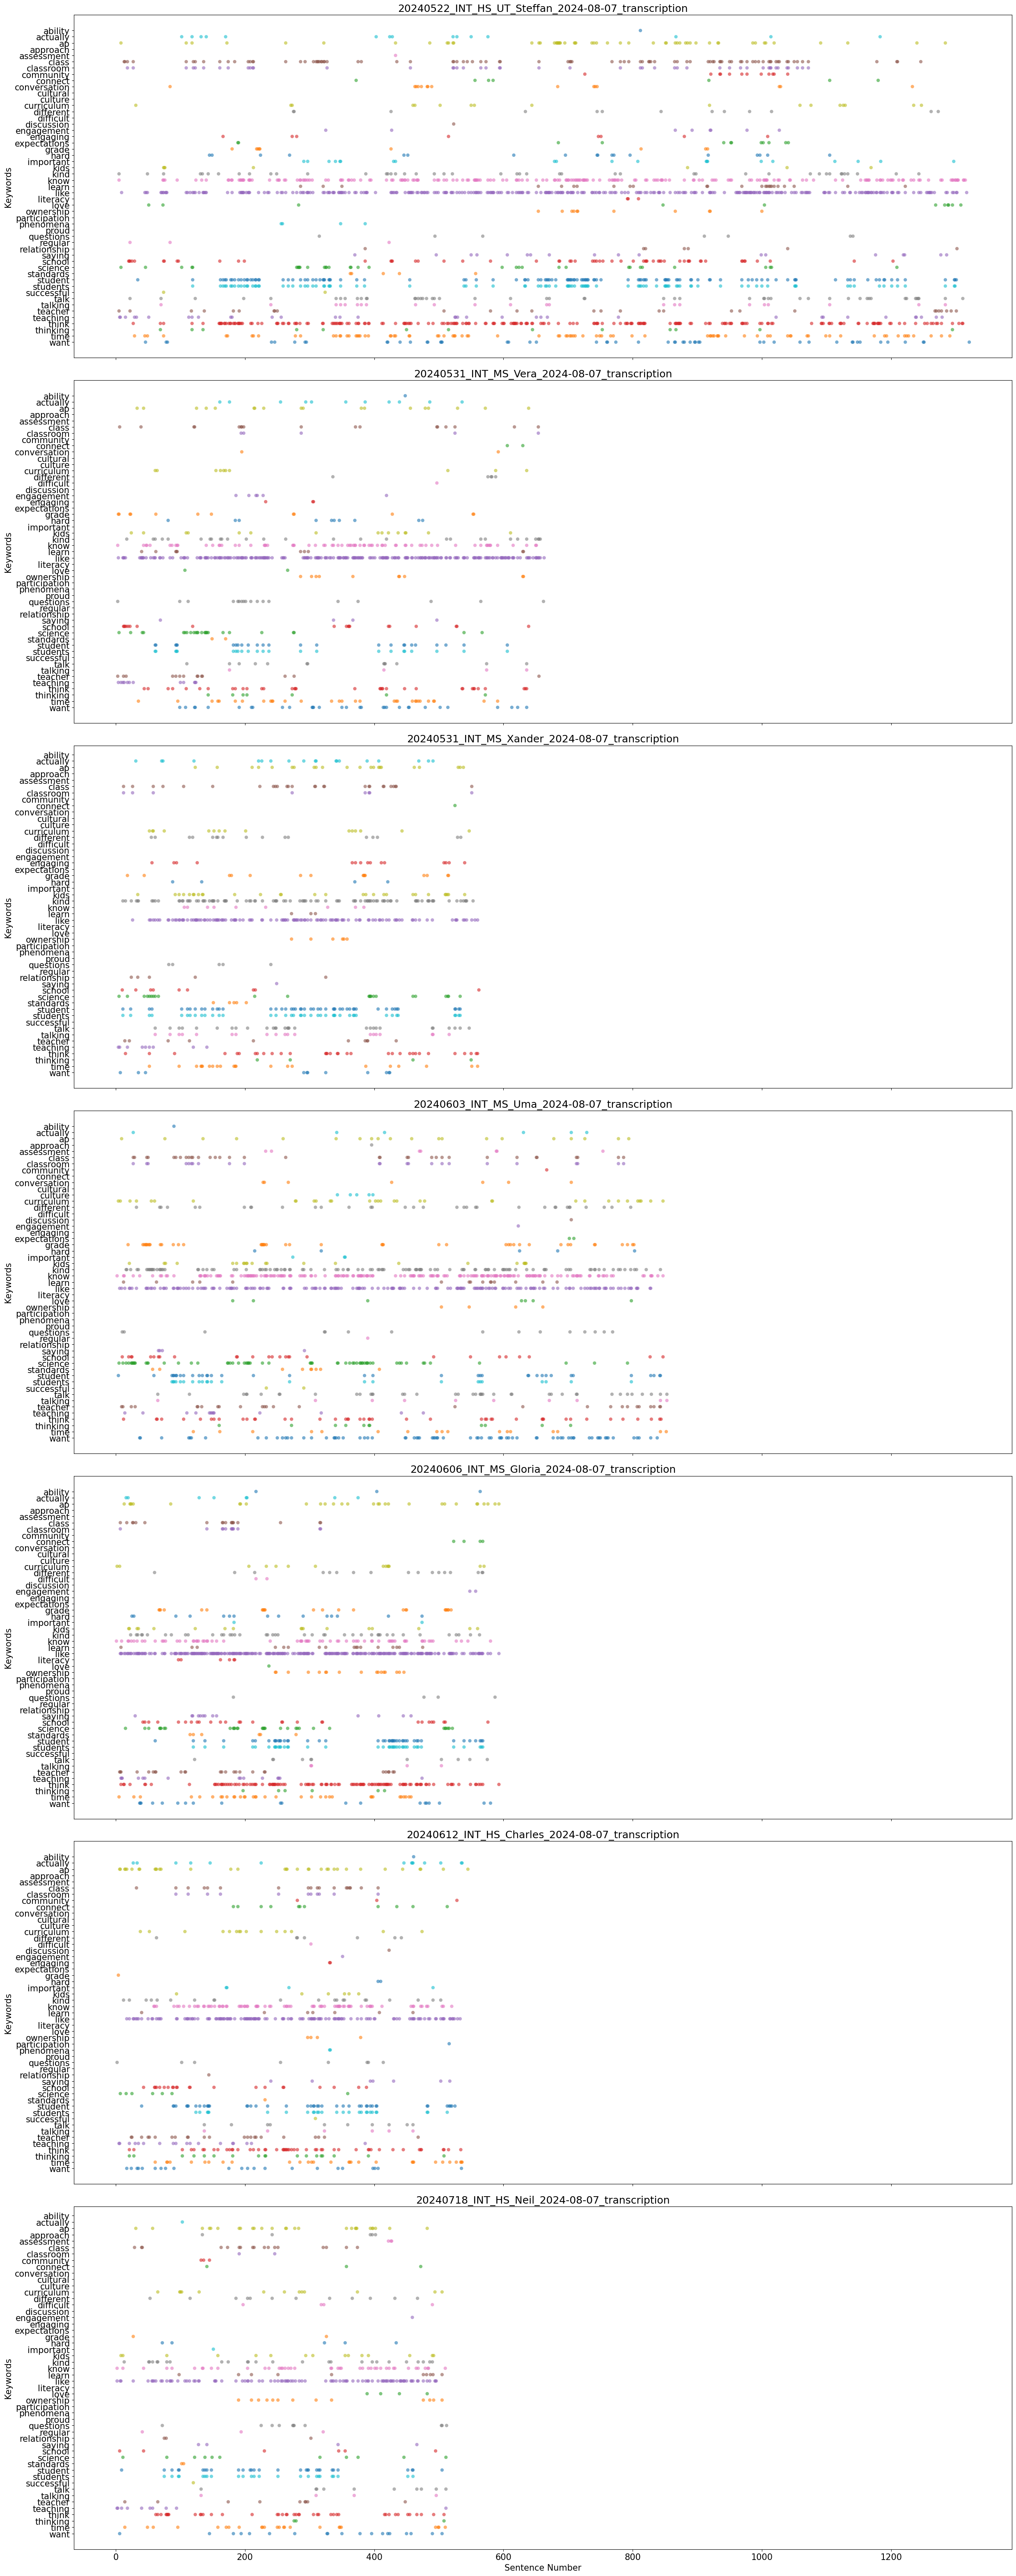

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Example keywords to track (remove duplicates and sort in reverse for plotting)
keywords = sorted(set([
    'students', 'science', 'engagement', 'ability', 'community', 'talk',
    'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations',
    'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
    'engaging', 'literacy', 'kids', 'connect', 'student', 'classroom',
    'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking',
    'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'questions',
    'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'conversation',
    'hard', 'saying'
]), reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Number of transcripts (corpora)
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig, axes = plt.subplots(num_corpora, 1, figsize=(25, num_corpora * 9), sharex=True)

# Convert axes to an array if it's not (happens when num_corpora is 1)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

# Iterate over each transcript and plot keyword occurrences
for ax, (i, (df, filename)) in zip(axes, enumerate(processed_transcripts)):
    corpus_name = os.path.basename(filename)
    ax.set_title(f"{corpus_name}")
    
    # Check if 'nltk_unprocessed_sentence_tokens' column exists
    if 'nltk_unprocessed_sentence_tokens' in df.columns:
        # Get the sentence tokens from each transcript
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        
        # Plot the occurrences of each keyword
        for keyword in keywords:
            occurrences = [(i + 1, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
            sentence_nums = [occ[1] for occ in occurrences]
            
            y_values = np.full(len(sentence_nums), keyword_mapping[keyword])
            ax.scatter(sentence_nums, y_values, label=keyword, alpha=0.6, edgecolors='none')
        
        ax.set_yticks(list(keyword_mapping.values()))
        ax.set_yticklabels(list(keyword_mapping.keys()))
        ax.set_ylabel('Keywords')
    else:
        print(f"'nltk_unprocessed_sentence_tokens' column not found in {filename}")
        continue  # Skip this transcript if the required column is missing

# Adjust layout and labels
plt.xlabel('Sentence Number')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure to an image file before displaying
plt.savefig('data/my_keyword_plots.png', bbox_inches='tight')

plt.show()
